In [18]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.losses import MeanSquaredError, KLDivergence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

# Data Load and Data Split

In [19]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Train set shape:    ", x_train.shape)
print("Train labels shape: ", y_train.shape)
print("Test set shape:     ", x_test.shape)
print("Test labels shape:  ", y_test.shape)

Train set shape:     (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test set shape:      (10000, 32, 32, 3)
Test labels shape:   (10000, 1)


## before normalization

In [20]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

## after normalization

In [21]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [22]:
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(8, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    return Model(inputs, [z_mean, z_log_var])

In [23]:
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(512, activation='relu')(latent_inputs)
    x = layers.Dense(8 * 8 * 8, activation='relu')(x)  # Adjust the shape according to your last encoder layer
    
    x = layers.Reshape((8, 8, 8))(x)  # Reshape according to the shape before flattening in encoder
    
    x = layers.Conv2DTranspose(16, 3, activation='relu', padding='same')(x)  # Inverse of Conv2D
    x = layers.UpSampling2D((2,2))(x)
    
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)  # Inverse of Conv2D
    x = layers.UpSampling2D((2,2))(x)
    
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)  # Inverse of Conv2D
#     x = layers.UpSampling2D((2,2))(x)
    
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)  # Inverse of Conv2D
    
    return Model(latent_inputs, outputs)


In [24]:
latent_dim = 128

In [25]:
encoder = build_encoder(x_train.shape[1:], latent_dim)
encoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     18,464 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 32)  │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 16)  │      4,624 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 4, 4, 16)  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 16)  │         64 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 8)   │      1,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 2, 2, 8)   │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 8)   │         32 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │     16,896 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     65,664 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     65,664 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 174,744 (682.59 KB)

 Trainable params: 174,504 (681.66 KB)

 Non-trainable params: 240 (960.00 B)

In [26]:
decoder = build_decoder(latent_dim)
decoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 32, 32, 3)      │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,739 (1.35 MB)

 Trainable params: 354,739 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed

    def reparameterize(self, mean, log_var):
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

vae = VAE(encoder, decoder)

In [28]:
vae.summary()

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_5 (Functional)       │ ?                      │       174,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ ?                      │       354,739 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,483 (2.02 MB)

 Trainable params: 529,243 (2.02 MB)

 Non-trainable params: 240 (960.00 B)

In [29]:
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

def vae_loss(x, x_reconstructed):
    reconstruction_loss = mse_loss(x, x_reconstructed)
    z_mean, z_log_var = vae.encoder(x)
    kl_loss_value = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss_value)


In [30]:
# Compile and train VAE model
vae.compile(optimizer=Adam(), loss=vae_loss, metrics = ["accuracy"])
early_stopper = EarlyStopping(monitor="val_loss", patience=10)

history_vae = vae.fit(
    x_train, x_train, 
    epochs=100, batch_size=128, 
    validation_data=(x_test, x_test),
    callbacks = [early_stopper]
)


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.4531 - loss: 0.0617 - val_accuracy: 0.4680 - val_loss: 0.0574
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4577 - loss: 0.0571 - val_accuracy: 0.4501 - val_loss: 0.0571
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4647 - loss: 0.0568 - val_accuracy: 0.4719 - val_loss: 0.0570
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4663 - loss: 0.0565 - val_accuracy: 0.4684 - val_loss: 0.0569
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4687 - loss: 0.0566 - val_accuracy: 0.4580 - val_loss: 0.0563
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4678 - loss: 0.0553 - val_accuracy: 0.4760 - val_loss: 0.0544
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4711 - loss: 0.0537 - val_accuracy: 0.4745 - val_loss: 0.0544
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4726 - loss: 0.0536 -

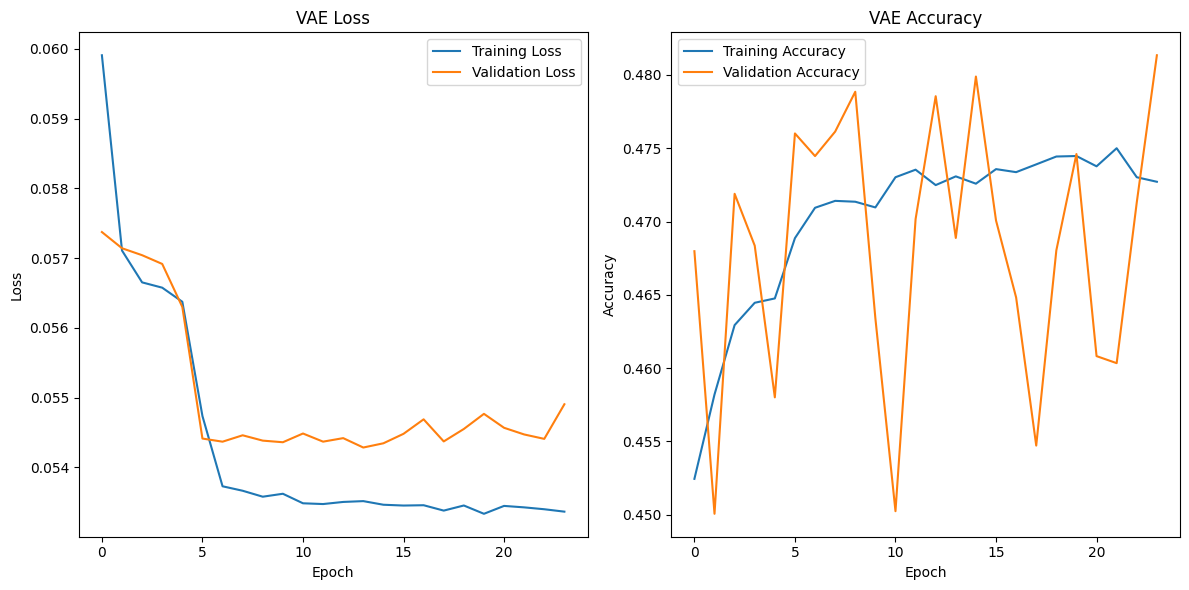

In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_vae.history['loss'], label='Training Loss')
plt.plot(history_vae.history['val_loss'], label='Validation Loss')
plt.title('VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_vae.history['accuracy'], label='Training Accuracy')
plt.plot(history_vae.history['val_accuracy'], label='Validation Accuracy')
plt.title('VAE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


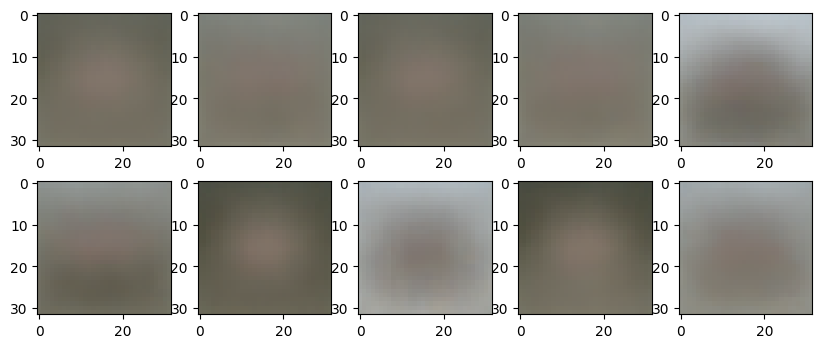

In [32]:
# Generate some samples
num_samples = 10
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
decoded_samples = decoder.predict(random_latent_vectors)

cols, rows = 2, 5

# Display generated samples
plt.figure(figsize=(10, 4))
for i in range(num_samples):
    plt.subplot(cols, rows, i + 1)
    plt.imshow(decoded_samples[i])
plt.show()